In [1]:
%pylab inline
import pandas as pd
from copy import deepcopy as copy
import scipy.optimize
from scipy import stats
import multiprocessing

Populating the interactive namespace from numpy and matplotlib


Use data through: 30th June 2012?

Chrome v1.0–v12.0, Firefox v1.0–v5.0, IE v4.0–v9.0, and Safari v1.0–v5.0.6

In [2]:
obs_samples = pd.read_pickle('_!obs_samples!_.pickle')

## Replicate the massacci nguyen test on polynomial models

In [3]:
def fit(row, error_func, guess, bounds):
    """
    Parameters
    ----------
    error : function
    """
    data = row.dropna()
    
    def func(paramlist, data):
        return error_func(paramlist, data)[0]
    
    res = scipy.optimize.minimize(fun=func, 
                                  x0=guess,
                                  method='L-BFGS-B',
                                  bounds=bounds,
                                  args=(data), 
                                  options={'maxiter':100})
    
    return pd.Series(error_func(res['x'],data), index=['chi2','pval'])

In [7]:
def model_LN(t, paramlist):
    """ Linear (LN) """
    A, B = paramlist
    return A*t + B

def model_RE(t, paramlist):
    """Rescorla Exponential (RE)"""
    B_0, B_1 = paramlist
    return B_0*log(1+B_1*t)

def error(paramlist, data, func=model_RE):
    data.dropna(inplace=True)
    output = [func(t, paramlist) for t in data.index]
    chi2 = stats.chisquare(data.values[1:], output[1:])
    return chi2.statistic, chi2.pvalue

error([1,2], obs_samples.iloc[0])


(73.670889127244152, 1.761548245709698e-14)

In [8]:
res = fit(obs_samples.iloc[0], error, [1,2], [(1e-6,1e6),(1e-6,1e6)])
res

chi2    1.079400
pval    0.955911
dtype: float64

In [9]:
a = obs_samples[:] 
res = a.apply(fit, axis=1, error_func=error,
              guess=[1,1], bounds=[(-1e6,1e6),(-1e6,1e6)])
print res.shape
res.head()

(5281, 2)


chi2          pval
DS  product version tseries                          
NVD chrome  1       6          1.078982  9.559472e-01
                    7         42.056609  1.792048e-07
                    8        279.026159  1.811325e-56
                    9         54.766209  4.901729e-09
                    10        18.401116  3.079498e-02

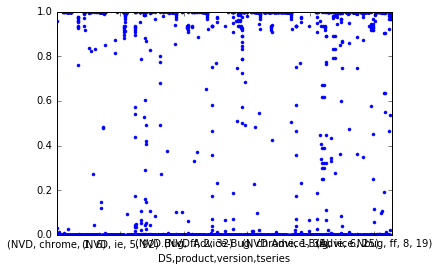

In [10]:
res['pval'].plot(linewidth=0, marker='.')

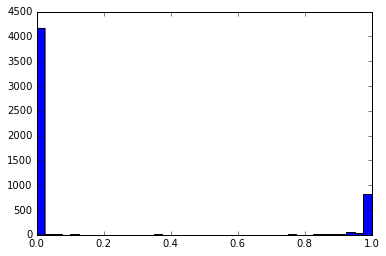

In [11]:
plt.hist(res['pval'], bins=40);

In [15]:
1.*((res['pval']>.8).sum()+/len(res)

0.18632834690399547

In [17]:
w = .5
Good = (res['pval']>.8).sum()
Inconclusive = (res['pval']>.2).sum() - Good
All = (res['pval']>-1).sum()

Q = (Good + .5*Inconclusive)/All
Q

0.19466010225336111

## Perform MN test on Circle Square model

In [132]:

import circlesquare

In [ ]:
def error(paramlist, data, iterations=1):
    """
    Runs the model with a specified set of parameters, and compares the
    error between the data set and the model output
    
    Parameters
    ----------
    paramlist : list of floats
        Parameter values for the model in array format, with elements:
        
        0. num_vulns: integer
                the number of vulnerabilities to include in the model
        
        1. max_area: float (0,1)
                the maximum likelihood that a vulnerability will be discovered
                
        2. burn_in : integer
                How many rounds of hardening to conduct before the timeseries starts?
                The burn-in period essentially allows the vulnerability distribution
                to approach that which we expect before release - that easy vulns 
                have been mostly found, and that harder ones remain.
        
        This is an array because the optimization routine
        expects to deal with things in this way.
        
    data : pandas Series
        Timeseries data to compare with the model output 
    
    iterations : integer (optional, default=1)
        How many times to run the simulation, averaging the error.
        This is desirable because the model is stochastic, and 
        multiple runs will give slightly different timeseries.
    
    Returns
    -------
    sse : float
        The sum of the squared error between the model runs and the data
        provided. Cumulative across all iterations.
    
    """
    sse = 0
    for _ in range(iterations):
        output = circlesquare.runner(num_vulns=paramlist[0],
                                     max_area=paramlist[1],
                                     tseries=data.index,
                                     burn_in=paramlist[2])
        errors = data - output
        sse += sum(errors**2)
    return sse

def fit(row):
    data = row.dropna()
    data
    
    res = scipy.optimize.minimize(error, [1000,.01,0],
                        method='L-BFGS-B',
                        bounds=[(0,1000),(0,1),(0,50)],
                        args=(data, 1), 
                        options={'maxiter':100})
    
    return res #pd.Series(index=['dec_%i_loss_rate'%i for i in range(1,10)], data=res['x'])

In [145]:
res = fit(Bug_cumulative.iloc[0])

1 loops, best of 3: 8min 4s per loop


0

In [162]:
_apply_df([Bug_cumulative[:4], fit, {'axis':1}])

0    1    2    3    4    5    6    7    8    9   ...   108  \
product version                                                   ...         
chrome  1        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN   
        2        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN   
        3        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN   
        4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN   

                 109  110  111  112  113  114  115  116  117  
product version                                               
chrome  1        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
        2        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
        3        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
        4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[4 rows x 118 columns]

In [155]:
%debug

> /Users/houghton/Google_Drive/MIT_Research/Cyber Security/Circle_Square_Model/circlesquare/circlesquare.py(477)runner()
    476     for t_1 in tseries:
--> 477         seeker.harden(t_1-t_0)
    478         round_counts.append({'round':model.rounds_hardened, 

ipdb> t_1
('chrome', 1)
ipdb> tseries
MultiIndex(levels=[[u'chrome', u'ff'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]],
           labels=[[0, 0, 0, 0], [0, 1, 2, 3]],
           names=[u'product', u'version'])
ipdb> tseries.index
*** AttributeError: 'MultiIndex' object has no attribute 'index'
ipdb> tseries.values
array([('chrome', 1), ('chrome', 2), ('chrome', 3), ('chrome', 4)], dtype=object)
ipdb> tseries.columns
*** AttributeError: 'MultiIndex' object has no attribute 'columns'

KeyboardInterrupt


In [161]:
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, workers, **kwargs):
    pool = multiprocessing.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

#res = apply_by_multiprocessing(Bug_cumulative[:4], fit, workers=4, axis=1)

In [148]:
%debug

> /Users/houghton/anaconda/lib/python2.7/multiprocessing/pool.py(567)get()
    566         else:
--> 567             raise self._value
    568 

ipdb> u
> /Users/houghton/anaconda/lib/python2.7/multiprocessing/pool.py(251)map()
    250         assert self._state == RUN
--> 251         return self.map_async(func, iterable, chunksize).get()
    252 

ipdb> u
> <ipython-input-147-66874e751aee>(7)apply_by_multiprocessing()
      6     pool = multiprocessing.Pool(processes=workers)
----> 7     result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
      8     pool.close()


KeyboardInterrupt
